In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/MS008_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,MS008-BT,0.0,0.0,0.00500,0.000000,0.0,0.005000,0.0,0.0,0.0
1,MS008-BT,12.0,0.0,1.08115,0.000000,0.0,0.337850,0.0,0.0,0.0
2,MS008-BT,24.0,0.0,0.96386,0.000000,0.0,0.202807,0.0,0.0,0.0
3,MS008-BU,0.0,0.0,0.00000,0.005000,0.0,0.005000,0.0,0.0,0.0
4,MS008-BU,12.0,0.0,0.00000,0.455992,0.0,0.565842,0.0,0.0,0.0


In [3]:
species = ['BU']
BT_data = gLV_data.iloc[np.in1d(gLV_data.Treatments.values, [f"Monoculture{sp}" for sp in species])]
BT_data = BT_data[["Treatments", "Time"] + species]
BT_data

,Treatments,Time,BU
200,MonocultureBU,0.0,0.023300
201,MonocultureBU,3.0,0.095600
202,MonocultureBU,6.0,0.287300
203,MonocultureBU,9.0,0.698700
204,MonocultureBU,12.0,0.801567
205,MonocultureBU,15.0,0.722433
206,MonocultureBU,18.0,0.694033
207,MonocultureBU,21.0,0.675700
208,MonocultureBU,24.0,0.721600
209,MonocultureBU,27.0,0.802433


# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def plot(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1])
        steps = len(t_eval)
        output, stdv, COV = model.predict_latent(x_test, t_eval)
        # output = model.predict_point(x_test, t_eval)

        # plot the results
        plt.figure(figsize=(9, 6))
        ylim = 0
        for i, sp in enumerate(species):
            out = output[:,i]
            out_true = output_true[:, i]
            if out[0] > 0:
                plt.scatter(tspan, out_true, color='C{}'.format(i))
                plt.plot(t_eval, out, label=f"Predicted {sp}", color='C{}'.format(i))
                plt.fill_between(t_eval, out-stdv[:, i], out+stdv[:, i], color='C{}'.format(i), alpha=0.2)
                
        plt.xlabel("Time (hr)")
        plt.ylabel("Species abundance")
        #plt.legend(loc='upper left')
        plt.title(f"C-R fit to monoculture")
        plt.savefig("figures/CR_mono_s.pdf")
        plt.show()
        
        # plot predictions of hidden variables
        for k in range(output.shape[-1] - (i+1)):
            plt.plot(t_eval, np.exp(output[:,i+1+k]), label=f"Predicted R{k+1}", color=f'C{k+1}')
            '''plt.fill_between(t_eval, 
                             np.exp(output[:,i+1+k] - stdv[:,i+1+k]), 
                             np.exp(output[:,i+1+k] + stdv[:,i+1+k]), 
                             color=f'C{k+1}', alpha=0.2)'''

        plt.legend()
        plt.ylabel("Resource concentration")
        plt.xlabel("Time (hr)")
        plt.savefig("figures/CR_mono_r.pdf")
        plt.show()

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 2

# death rate 
d = -5*np.ones(n_s)

# maximum consumption rate parameters
C = np.zeros([n_r, n_s])

# maximum production rate parameters
# P = -np.ones([n_r, n_s])

# concatenate parameters 
params = np.concatenate((d, C.flatten()))
prior  = np.copy(params)

n_params = len(params)
n_params

3

# Define model

In [6]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # death rate
    d = jnp.exp(params[:n_s])
    
    # consumption rate parameters
    C = jnp.exp(np.reshape(params[n_s:n_s+n_r*n_s], [n_r, n_s]))
    
    # production rate parameters
    # P = jnp.exp(np.reshape(params[n_s+n_r*n_s:], [n_r, n_s]))
    
    # rate of change of species 
    dsdt = s*(C.T@r - d) 

    # rate of change of log of resources 
    dlrdt = -C@s 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [7]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0.]])

# Fit model to mono culture data

In [8]:
r0 = np.random.uniform(-2, 0, n_r)
print(r0)

model = ODE(system = system, 
            dataframe=BT_data,
            C=O,
            CRparams = params, 
            r0 = r0,
            prior = prior,
            species = species,
            alpha_0=1e-3,
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, nlp_tol=1e-3)
print("Elapsed time {:.2f}s".format(time.time()-t0))

[-0.60706163 -1.42772133]
Updating precision...
Total samples: 22, Updated regularization: 1.00e-03
Total weighted fitting error: 0.317
Total weighted fitting error: 0.111
Total weighted fitting error: 0.078
Total weighted fitting error: 0.062
Total weighted fitting error: 0.060
Total weighted fitting error: 0.056
Total weighted fitting error: 0.056
Total weighted fitting error: 0.055
Total weighted fitting error: 0.054
Total weighted fitting error: 0.053
Total weighted fitting error: 0.053
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.052616785586379944
       x: [-5.938e-01 -1.373e+00 -7.703e+00 -5.524e-01 -2.296e-01]
     nit: 11
     jac: [-2.076e-02 -1.001e-02  2.702e-03 -2.860e-03 -1.048e-03]
    nfev: 13
    njev: 13
    nhev: 11
Evidence -8.277
Updating precision...
Total samples: 22, Updated regularization: 3.27e-04
Total weighted fitting error: 0.444
Total weighted fitting error: 0.444
 message: Optimization terminated successfully.
 s

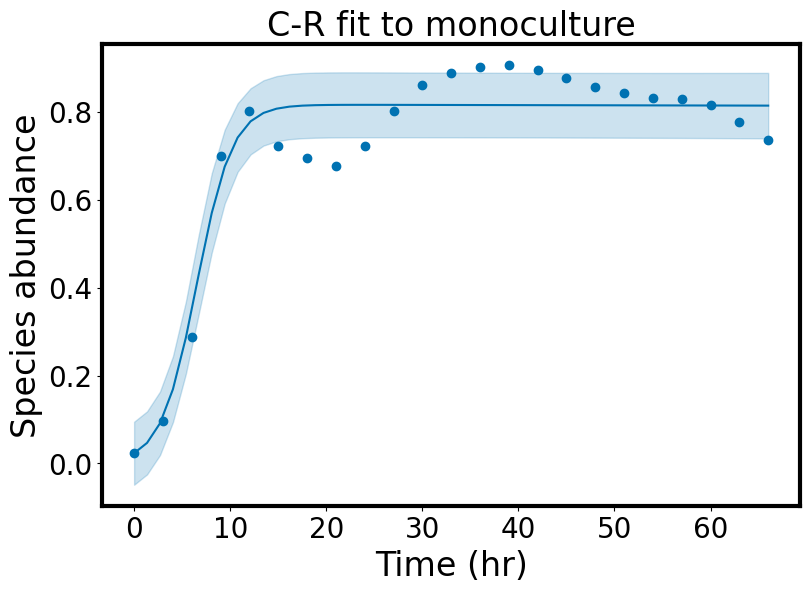

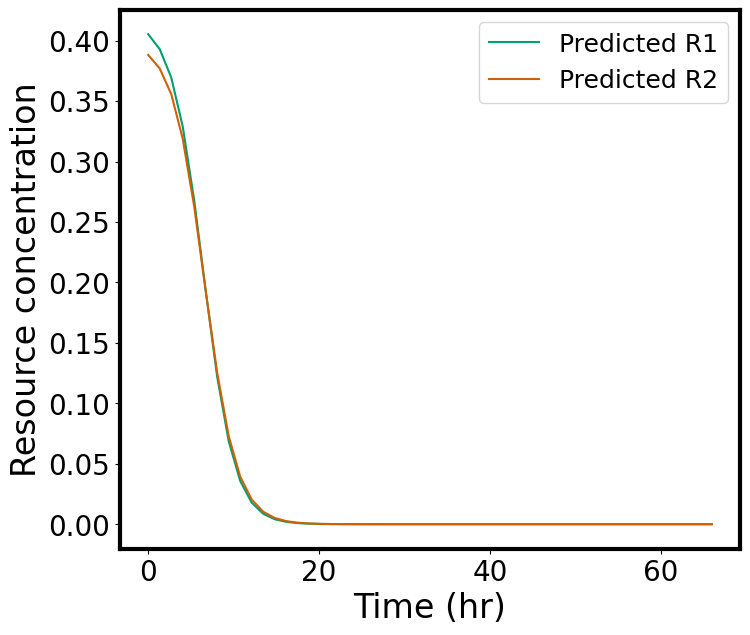

In [9]:
plot(model, BT_data)

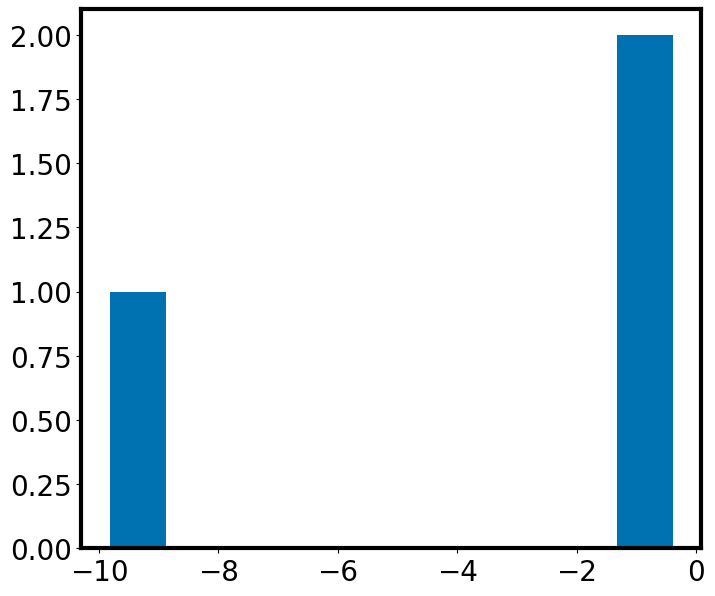

In [11]:
params = model.params[n_r:]
plt.hist(params)
plt.show()

In [12]:
# death rate
d = np.exp(params[:n_s])
d

array([5.42944343e-05])